## Imported required libraries

In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import glob
from keras.utils import np_utils

from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16



from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import model_from_json

import math


import random



from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

import h5py

## Data Exploratory

<Figure size 432x288 with 0 Axes>

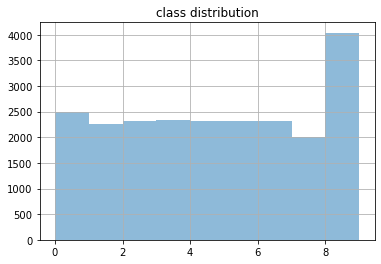

In [25]:
img_list = pd.read_csv('/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/driver_imgs_list.csv')
img_list['class_type'] = img_list['classname'].str.extract('(\d)',expand=False).astype(float)
plt.figure()
# visualize the distribution of classes in the dataset.
img_list.hist('class_type',alpha=0.5,layout=(1,1),bins=9)
plt.title('class distribution')
plt.draw()
plt.show()

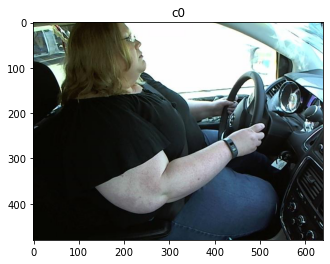

In [26]:
path = os.path.join( '/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/imgs/train/c0/img_104.jpg')
import matplotlib.image as mpimg

# loads an image from the path
img=mpimg.imread(path)
#resized = cv2.resize(img, (100, 80), cv2.INTER_LINEAR)
plt.title('c0')
plt.imshow(img)
plt.show()

# Data Preprocessing
### When we import the dataset, we need to resize the orignal image first, here is the example

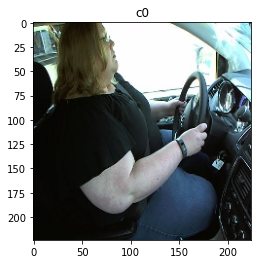

In [27]:
# resizes the image read from the path to a size of (224, 224) using the OpenCV
resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
plt.title('c0')
plt.imshow(resized)
plt.show()

### We want all image to be substracted by the mean value, the example is shown below:preprocessing steps for image classification tasks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


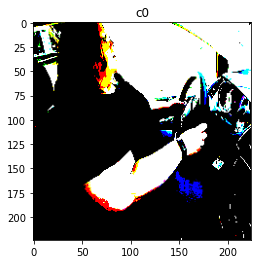

In [28]:
# image is converted to a float32 datatype to be compatible with the pre-trained model
resized = resized.astype('float32')

# mean pixel values of the ImageNet dataset
mean = [103.939,116.779,123.68]

# mean pixel values for each channel (BGR) are subtracted from the image.
resized[:, :, 0] -= mean[0]   
resized[:, :, 1] -= mean[1]
resized[:, :, 2] -= mean[2]
plt.title('c0')
plt.imshow(resized)
plt.show()
    
    

### Create training input
### Load the data and resize to create training set.

In [29]:
# used to load the images and their corresponding labels into memory:y_train contains label
X_train = []
y_train = []

# reading all the image files present in that class folder using the glob function
# cv2.INTER_LINEAR is one of the commonly used interpolation methods in image processing, which uses a weighted average of four neighboring pixels to estimate the value of a new pixl.
for i in range(10):    
    path = os.path.join( '/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/imgs/train/c' + str(i), '*.jpg')
    files = glob.glob(path)
    for fl in files:
        img = cv2.imread(fl)
        img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
        X_train.append(img)
        y_train.append(i)

In [32]:
# converting with numpy arrays with data type np.uint8
X_train = np.array(X_train, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)

In [33]:
# X_train is converted to a float16 data type done to reduce the memory usage during training
X_train = X_train.astype('float16')
# converts the target variable y_train into a binary matrix of size (n_samples, n_classes), where n_samples is the number of training samples and n_classes is the number of classes (in this case, 10
y_train = np_utils.to_categorical(y_train, 10)

In [34]:
# operation centers the pixel values around zero and reduces the effects of lighting conditions
mean = [103.939,116.779,123.68]
X_train[:, :, :, 0] -= mean[0]   
X_train[:, :, :, 1] -= mean[1]
X_train[:, :, :, 2] -= mean[2]

print('the shape of training set: ', X_train.shape)

the shape of training set:  (22424, 224, 224, 3)


# Training Model Design

In [35]:
# importing the ResNet50 model from the Keras library.
from tensorflow.keras.applications.resnet50 import ResNet50
# creating an instance of the ResNet50 model with the pre-trained weights from the ImageNet dataset
model_resnet50_conv = ResNet50(weights='imagenet', include_top=False)
 
model_resnet50_conv.summary()

input = Input(shape=(224,224,3),name = 'image_input')
#  passes the input layer to the ResNet50 model to obtain its output
output_resnet50_conv = model_resnet50_conv(input)
# flattens the output from the ResNet50 model into a one-dimensional vector.
x = Flatten()(output_resnet50_conv)
# adds a fully connected layer with 10 output units and a softmax activation function.
x = Dense(10, activation='softmax', name='predictions')(x)
# creates a new model that takes the input layer and produces the output from the fully connected layer.
model = Model(input,x)

model.summary()
# compiles the model with the Adam optimizer, a learning rate of 1e-5, categorical crossentropy as the loss function, and accuracy as the metric to monitor during training.
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_12[0][0]']               
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

# Resnet50

In [6]:
def train_model():
    model_resnet50_conv = ResNet50(weights='imagenet', include_top=False)
 
    input = Input(shape=(224,224,3),name = 'image_input')
 
    output_resnet50_conv = model_resnet50_conv(input)
   
    x = Flatten()(output_resnet50_conv)
    #x = Dropout(0.3)(x)
    x = Dense(10, activation='softmax', name='predictions')(x)
    
    model = Model(input,x)
   
    model.compile(Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [38]:
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.display import Image, SVG
model=train_model()
plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train Model and Save

number 1 fold of 2 folds cross validation
Split into training and validation set 11212 11212
Epoch 1/3
351/351 [==============================] - ETA: 0s - loss: 1.2246 - accuracy: 0.7839
Epoch 1: val_loss improved from inf to 0.26378, saving model to Users\malay\OneDrive\Desktop\distracted\weights_1.h5
351/351 [==============================] - 2377s 7s/step - loss: 1.2246 - accuracy: 0.7839 - val_loss: 0.2638 - val_accuracy: 0.9265
Epoch 2/3
351/351 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9650
Epoch 2: val_loss did not improve from 0.26378
351/351 [==============================] - 2316s 7s/step - loss: 0.1272 - accuracy: 0.9650 - val_loss: 0.5171 - val_accuracy: 0.8657
Epoch 3/3
351/351 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.9704
Epoch 3: val_loss did not improve from 0.26378
351/351 [==============================] - 2314s 7s/step - loss: 0.1152 - accuracy: 0.9704 - val_loss: 4.6586 - val_accuracy: 0.6807


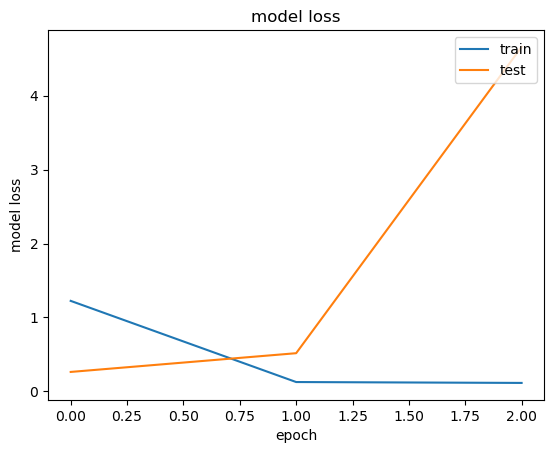

KeyError: 'acc'

In [17]:
 foldn=0
n_folds=2
log_list=[]
# shuffling the data before splitting it into folds
np.random.seed(2016)
# KFold object is used to split the dataset into training and validation sets.
kf = KFold(n_splits=n_folds,random_state=51,shuffle=True,)

for train, test in kf.split(X_train):
    model = train_model()        
    foldn += 1
    
    print('number {} fold of {} folds cross validation'.format(foldn, n_folds))
    print('Split into training and validation set', len(X_train[train]), len(X_train[test]))   
        
    weights_path = os.path.join('Users','malay','OneDrive','Desktop','distracted','weights_' + str(foldn) + '.h5')
    
# early stopping callback monitors the validation loss and stops training if the loss does not improve after a certain number of epochs (defined by the patience parameter).
# model checkpointing callback saves the best model weights based on the validation loss, so that the model can be restored later if needed.
    callbacks = [                
                EarlyStopping(monitor='val_loss', patience=10, verbose=0),
                ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),                
                ]
    
#     training the model on the training set (X_train[train] and y_train[train]) using the validation set (X_train[test] and y_train[test]) for validation during each epoch
    log=model.fit(X_train[train], y_train[train], batch_size=32, epochs=3,
                  shuffle=True, verbose=1, validation_data=(X_train[test],y_train[test]),
                  callbacks=callbacks)
          
    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train','test','val_train','val_test'], loc='upper right')
    plt.show()
    
    plt.plot(log.history['acc'])
    plt.plot(log.history['val_acc'])
    plt.title('model acc')
    plt.ylabel('model acc')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper right')
    plt.show()

# Save Model


In [21]:
with open('/Users/malay/OneDrive/Desktop/distracted/model.json', 'w') as f:
    f.write(model.to_json())

In [1]:
# import sys
# !{sys.executable} -m pip install keras


# Sample Prediction

In [4]:
def predict(path):

    X_test = []
    X_test_id = []


    #fl = os.path.basename(path)
    img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)

    X_test.append(resized)
    
    
    test_data = np.array(X_test, dtype=np.uint8)
    test_data = test_data.astype('float16')   
    mean_pixel = [103.939, 116.779, 123.68]
    print('Substract mean')
    test_data[:, :, :, 0] -= mean_pixel[0]   
    test_data[:, :, :, 1] -= mean_pixel[1]
    test_data[:, :, :, 2] -= mean_pixel[2]
    model=train_model()
    weights_path = os.path.join('/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/weights_1.h5')
    model.load_weights(weights_path)

    test_prediction = model.predict(test_data,verbose=1)
    result=str(np.argmax(test_prediction))
    return img,result

# Defined all class with actions

In [8]:
results = {'0': 'normal driving','1': 'texting - right','2': 'talking on the phone - right','3': 'texting - left','4': 'talking on the phone - left','5':'operating the radio','6': 'drinking','7': 'reaching behind','8': 'hair and makeup','9': 'talking to passenger'}

# Prediction using frame 

Substract mean
1/1 [==============================] - 1s 1s/step


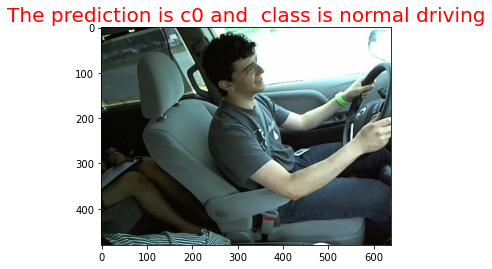

In [12]:
path2 = os.path.join('/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/imgs/test/img_51.jpg')
img,result=predict(path2)
plt.title('The prediction is c'+result+' '+'and  class is'+' '+results[result],color='red',fontsize=20)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Substract mean
1/1 [==============================] - 2s 2s/step


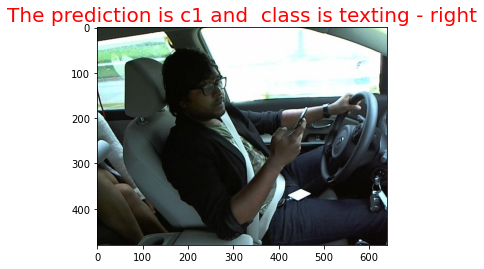

In [90]:
path2 = os.path.join('/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/imgs/test/img_12.jpg')
img,result=predict(path2)
plt.title('The prediction is c'+result+' '+'and  class is'+' '+results[result],color='red',fontsize=20)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Substract mean
1/1 [==============================] - 1s 1s/step


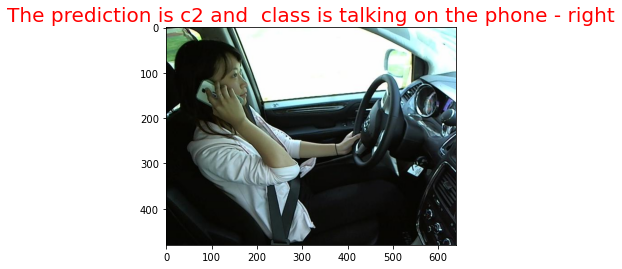

In [91]:
path2 = os.path.join('/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/imgs/test/img_2.jpg')
img,result=predict(path2)
plt.title('The prediction is c'+result+' '+'and  class is'+' '+results[result],color='red',fontsize=20)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Substract mean
1/1 [==============================] - 1s 1s/step


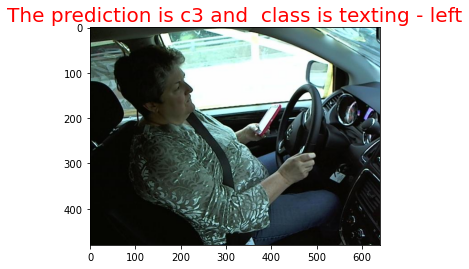

In [92]:
path2 = os.path.join('/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/imgs/test/img_7.jpg')
img,result=predict(path2)
plt.title('The prediction is c'+result+' '+'and  class is'+' '+results[result],color='red',fontsize=20)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Substract mean
1/1 [==============================] - 1s 1s/step


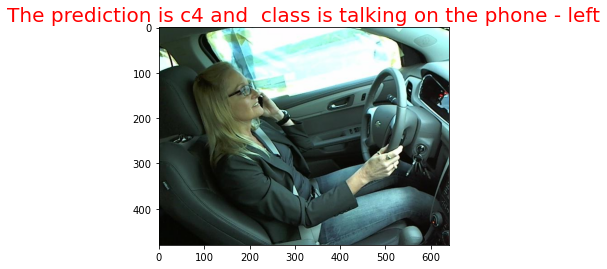

In [93]:
path2 = os.path.join('/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/imgs/test/img_14.jpg')
img,result=predict(path2)
plt.title('The prediction is c'+result+' '+'and  class is'+' '+results[result],color='red',fontsize=20)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Substract mean
1/1 [==============================] - 1s 1s/step


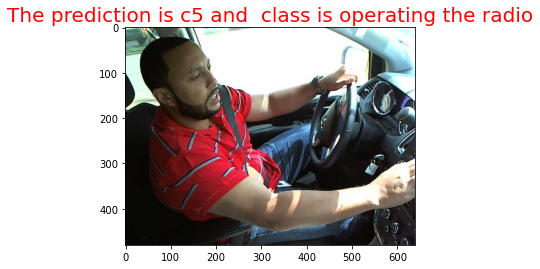

In [94]:
path2 = os.path.join('/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/imgs/test/img_9.jpg')
img,result=predict(path2)
plt.title('The prediction is c'+result+' '+'and  class is'+' '+results[result],color='red',fontsize=20)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Substract mean
1/1 [==============================] - 1s 1s/step


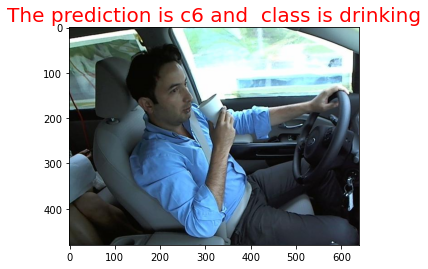

In [95]:
path2 = os.path.join('/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/imgs/test/img_18.jpg')
img,result=predict(path2)
plt.title('The prediction is c'+result+' '+'and  class is'+' '+results[result],color='red',fontsize=20)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Substract mean
1/1 [==============================] - 1s 1s/step


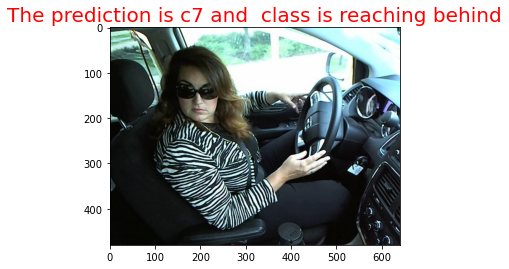

In [96]:
path2 = os.path.join('/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/imgs/test/img_57.jpg')
img,result=predict(path2)
plt.title('The prediction is c'+result+' '+'and  class is'+' '+results[result],color='red',fontsize=20)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Substract mean
1/1 [==============================] - 1s 1s/step


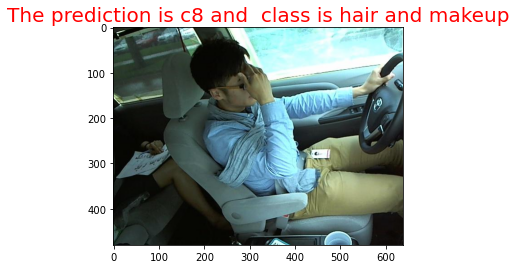

In [99]:
path2 = os.path.join('/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/imgs/test/img_2464.jpg')
img,result=predict(path2)
plt.title('The prediction is c'+result+' '+'and  class is'+' '+results[result],color='red',fontsize=20)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Substract mean
1/1 [==============================] - 1s 1s/step


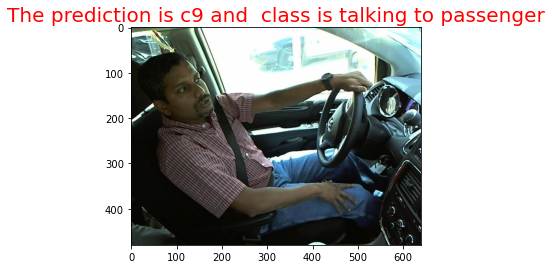

In [11]:
path2 = os.path.join('/Users/sonukumar/Desktop/Distracted_Driver_Detection-master/imgs/test/img_382.jpg')
img,result=predict(path2)
plt.title('The prediction is c'+result+' '+'and  class is'+' '+results[result],color='red',fontsize=20)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()